In [3]:
import numpy as np
from scipy import constants as c
from scipy import special as sp
from iminuit import Minuit, cost
import os
import matplotlib.pyplot as plt
import h5py as h5
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from IPython.display import display, Math

In [4]:
KB = c.Boltzmann
hbar = c.Planck

In [5]:
def resonance_model(x, Q, Qc,phi0):
    return 1-Q/Qc*np.exp(1j*phi0)/(1+1j*((2*x*Q)))

def resonance_model2(x, Q, Qc,phi0):
    return abs(1-Q/Qc*np.exp(1j*phi0)/(1+1j*((2*x*Q))))

def model(x, m, q, Q, Qc,phi0):
    params = np.array([m,q])
    pol = np.polyval(params, x)
    res = resonance_model(x, Q,Qc,phi0)
    return np.abs(res)+pol

def FWHM(x,y):
    x = np.array(x)
    y = np.array(y)
    half = np.max(y) - (np.max(y)-np.abs(y)) / 2.
    minimums = x[np.where(y < half)]
    return (max(minimums) - min(minimums))

def mod(x,y):
    return np.sqrt(x**2 + y**2)
    
def Q_stima(x0,w):
    if (((x0 is None) or (w is None)) or w==0):
        print('Q_stima: None detected!')
        return 0
    else:
        return x0/(2*w)
    
def Sort_Tuple(tup):
 
    # getting length of list of tuples
    lst = len(tup)
    for i in range(0, lst):
        for j in range(0, lst-i-1):
            if (tup[j][1] > tup[j + 1][1]):
                temp = tup[j]
                tup[j] = tup[j + 1]
                tup[j + 1] = temp
    return tup

def read_files(dir = 'C:\\Users\\ricca\\Desktop\\QTLab2324\\IRdetection\\Instruments\\Test_data\\data_20_02_set2\\'):

    dfs, dictionaries, temps = [], [], []

    for folder in os.listdir(dir):
        if ('T' in folder):
            temps.append(int(str(folder).replace('T_','')))
            parent = dir+folder+'\\'
            dictionaries = []
            for (i,filename) in enumerate(os.listdir(parent)):
                my_dest = filename.replace('.h5','.hdf5')
                my_source = parent + filename
                my_dest = parent + my_dest
                os.rename(my_source, my_dest)
                with h5.File(my_dest, 'r') as r:
                    group = r.require_group(name='raw_data')
                    dic = dict()
                    for c in group.items():
                        dic[c[0]] = c[1][:]
                dictionaries.append(dic)
        dfs.append(dictionaries)
    return dfs, temps

In [6]:
dfs, temps = read_files()
min_freq = []
for i in range(len(dfs)):
    for j in range(4):
        dfs[i][j]['S21'] = np.sqrt(np.array(dfs[i][j]['i'])**2 + np.array(dfs[i][j]['q'])**2)
        min_freq.append(dfs[i][j]['f'][np.argmin(dfs[i][j]['S21'])])

We have to estimate $\sigma$\
To do this we will grab the first 100 data points and get the _RMS_

In [7]:
rms = []
for i in range(len(dfs)):
    for j in range(4):
        condition = lambda x: (x<min_freq[i*4+j]*(1-0.9)*1e9)
        fs = [x for x in dfs[i][j]['f'] if condition(x)]
        filtered_indices = [k for k, x in enumerate(dfs[i][j]['f']) if condition(x)]
        S21s = [dfs[i][j]['S21'][k] for k in filtered_indices]

        order = 1 
        pol_amp = np.polyfit(fs, S21s, order)
        rms.append(np.sqrt(np.mean((np.polyval(pol_amp, fs)-S21s)**2)))

**Let's use data around the resonance minimum**

In [8]:
for i in range(len(dfs)):
    for j in range(4):
        condition2 = lambda x: (x>min_freq[i*4+j]*(1-0.02) and x<min_freq[i*4+j]*(1+0.02))
        filtered_indices2 = [i for i, x in enumerate(dfs[i][j]['f']) if condition2(x)]
        f = [x for x in dfs[i][j]['f'] if condition2(x)]
        S21 = [dfs[i][j]['S21'][k] for k in filtered_indices2]

In [9]:
for i in range(len(dfs)):
    for j in range(4):
        dfs[i][j]['f'] = (dfs[i][j]['f']-min_freq[i*4+j])/min_freq[i*4+j]
        dfs[i][j]['S21'] = dfs[i][j]['S21']/max(dfs[i][j]['S21'])

Now we have to estimate resonance parameters: $Q$, $Q_{c}$, $\phi_{0}$

In [10]:
p0 = []
for i in range(len(dfs)):
    for j in range(4):
        m, q = np.polyfit(dfs[i][j]['f'], dfs[i][j]['S21'],1)
        p0.append([m, q, 1.3e4, 1e3,-0.077])
        
#f0_init = f[np.argmin(S21)]

#Q_init = Q_stima(f0_init,FWHM(f,S21))
#Qc_init = 1.2e3
#phi0_init = 0.01
#p0_names = ['m','q', '$Q_{i}$', '$Q_{c}$', r'\phi_{0}']
#bounds = [(None, None, None, min_freq*(1-0.1)), (None, None, None,min_freq*(1+0.1))]


In [11]:
lsq, m = [], []
for i in range(len(dfs)):
    for j in range(4):
        lsq.append(cost.LeastSquares(dfs[i][j]['f'], dfs[i][j]['S21'], rms[i*4+j], model))
        m.append(Minuit(lsq[i*4+j], *p0[i*4+j]))
        m[i*4+j].migrad(ncall=10000)

<>:16: SyntaxWarning: invalid escape sequence '\c'
<>:16: SyntaxWarning: invalid escape sequence '\c'
C:\Users\ricca\AppData\Local\Temp\ipykernel_13584\3917824438.py:16: SyntaxWarning: invalid escape sequence '\c'
  f"$\chi^{2}_{0}$ = {chi2/ndof:.4f}",
C:\Users\ricca\AppData\Local\Temp\ipykernel_13584\3917824438.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


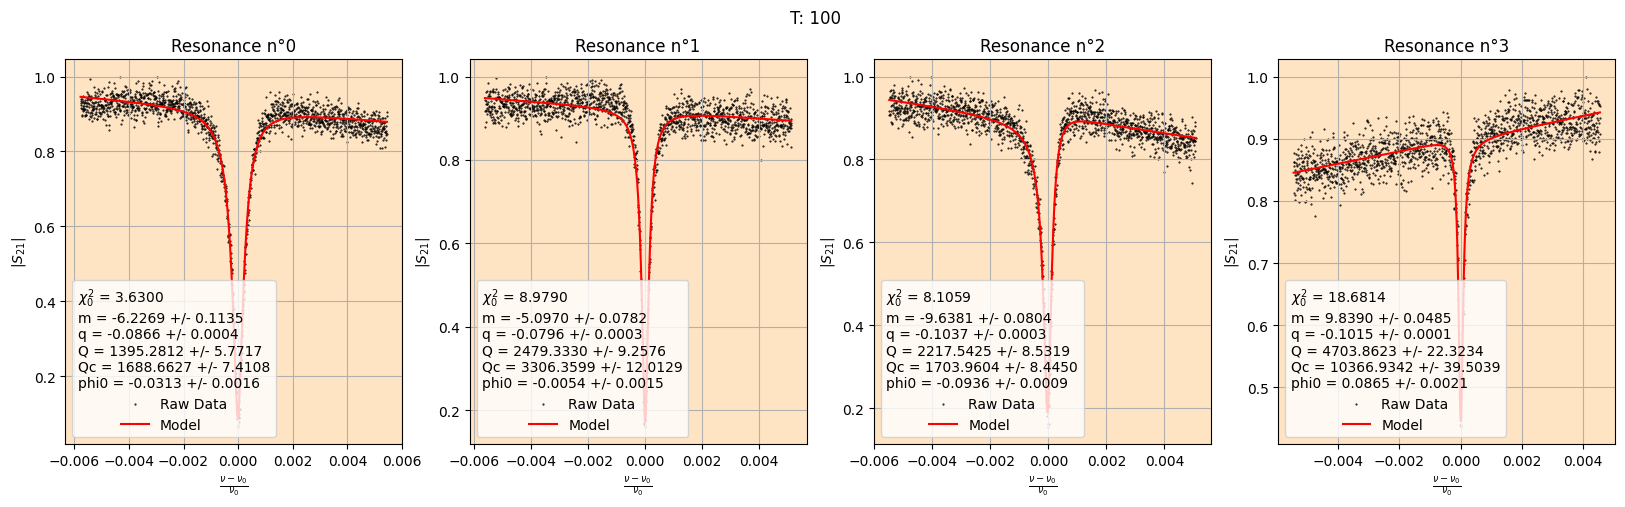

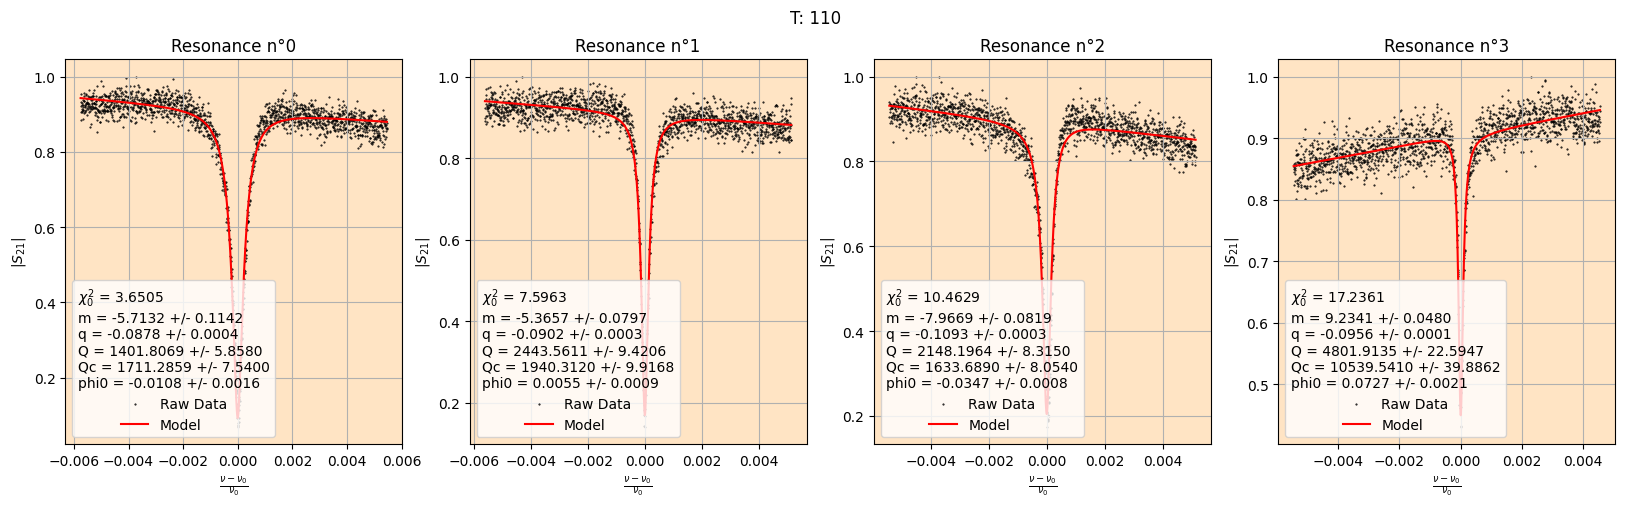

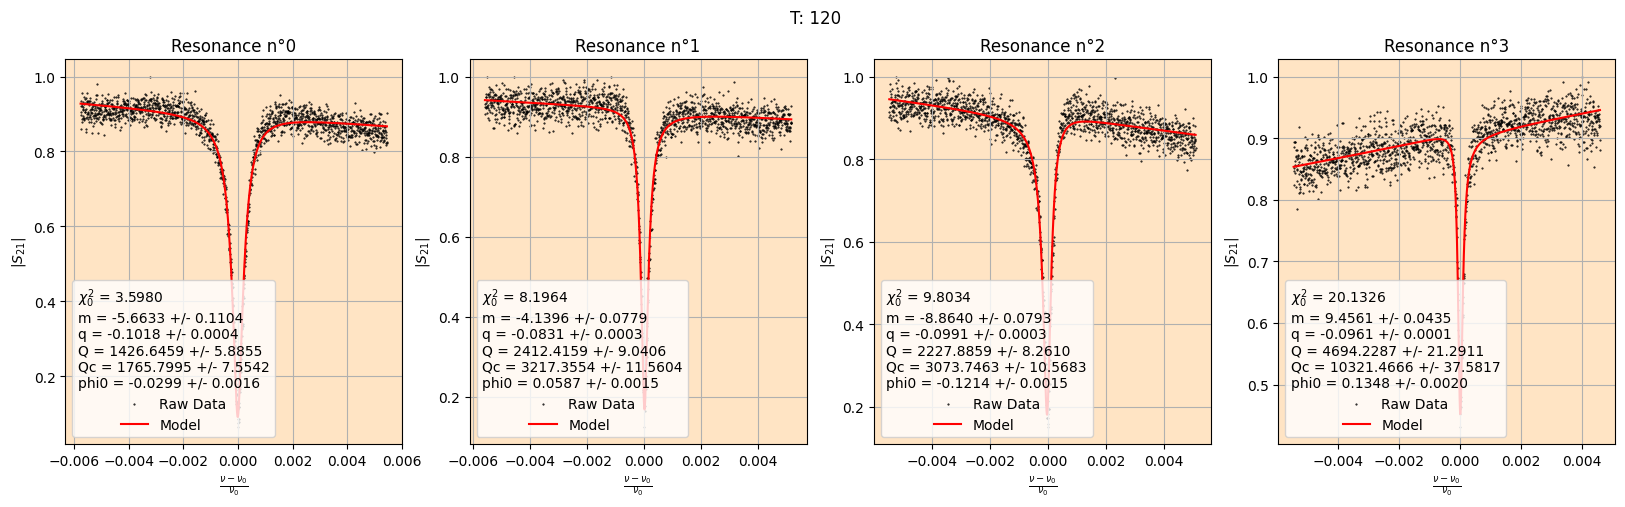

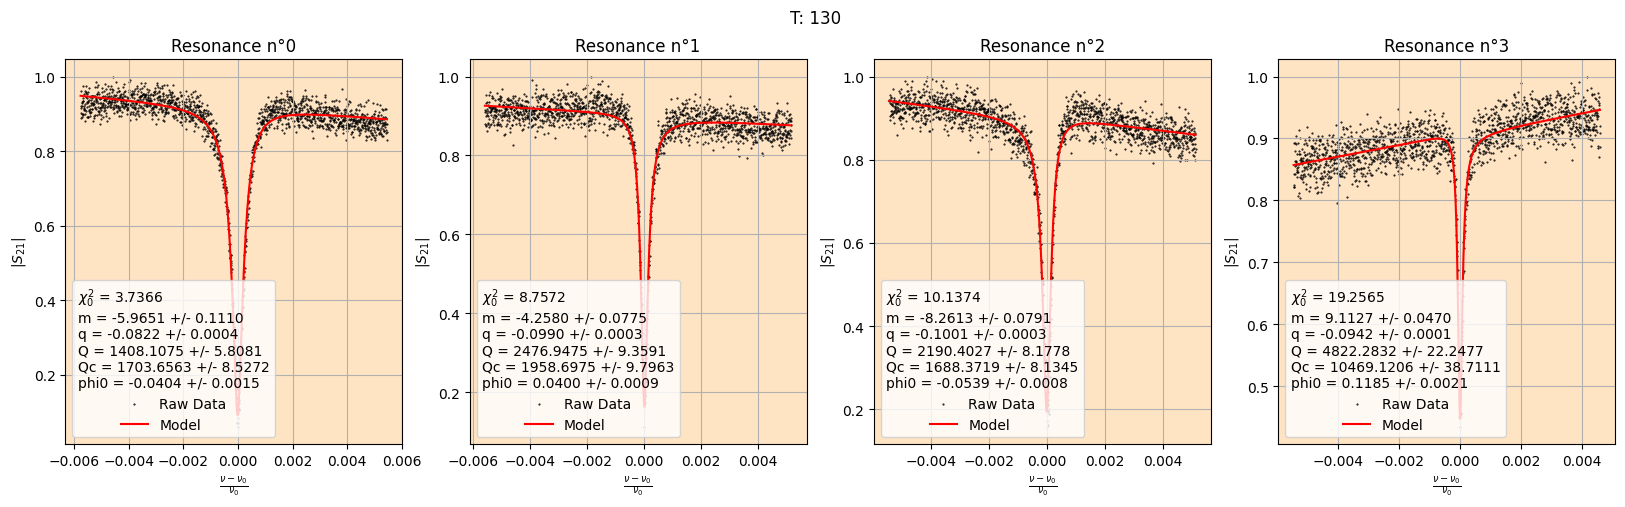

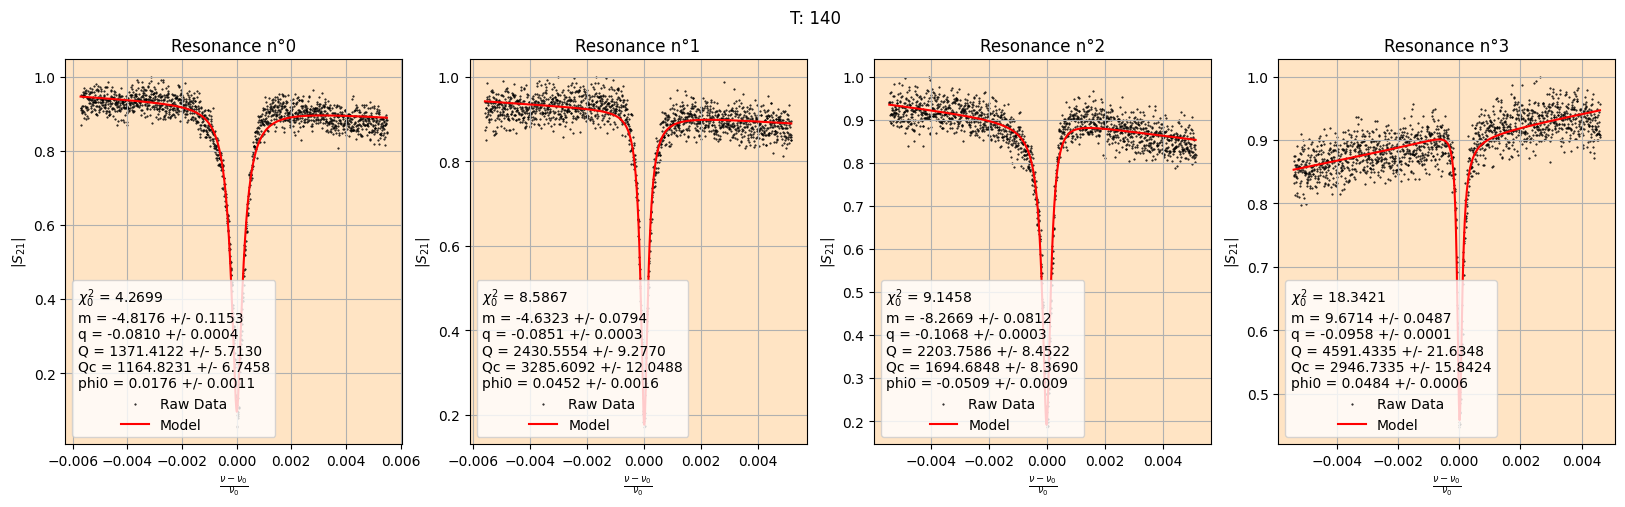

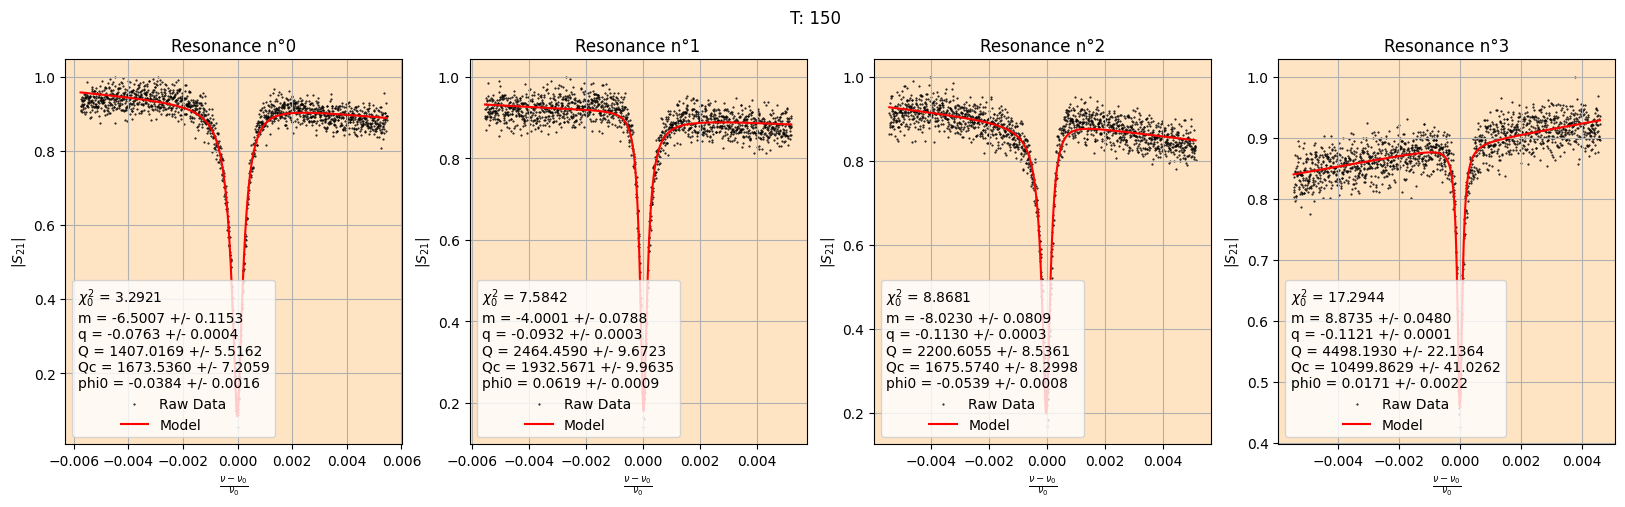

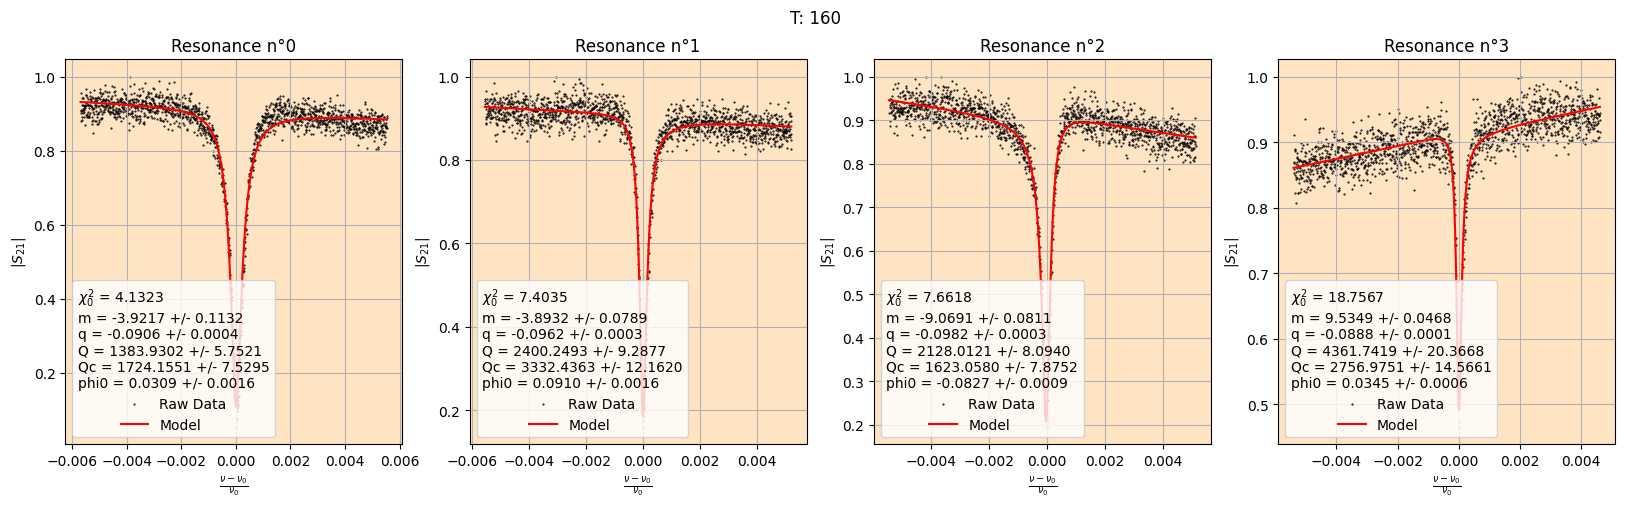

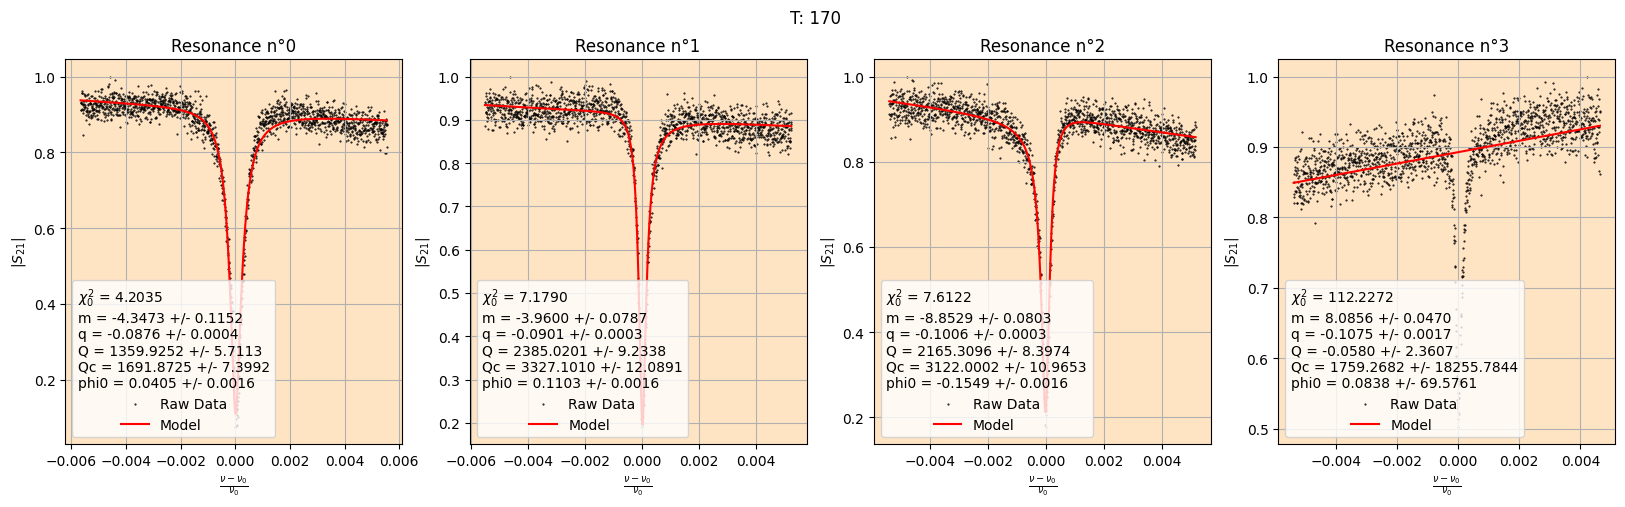

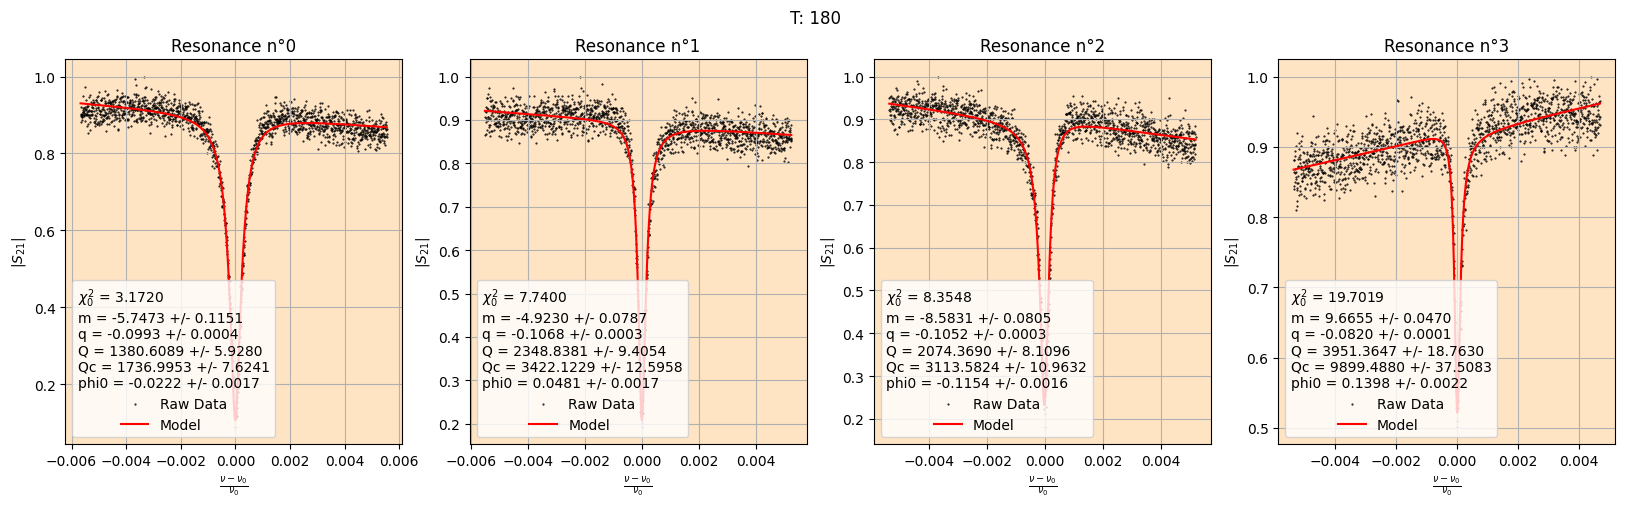

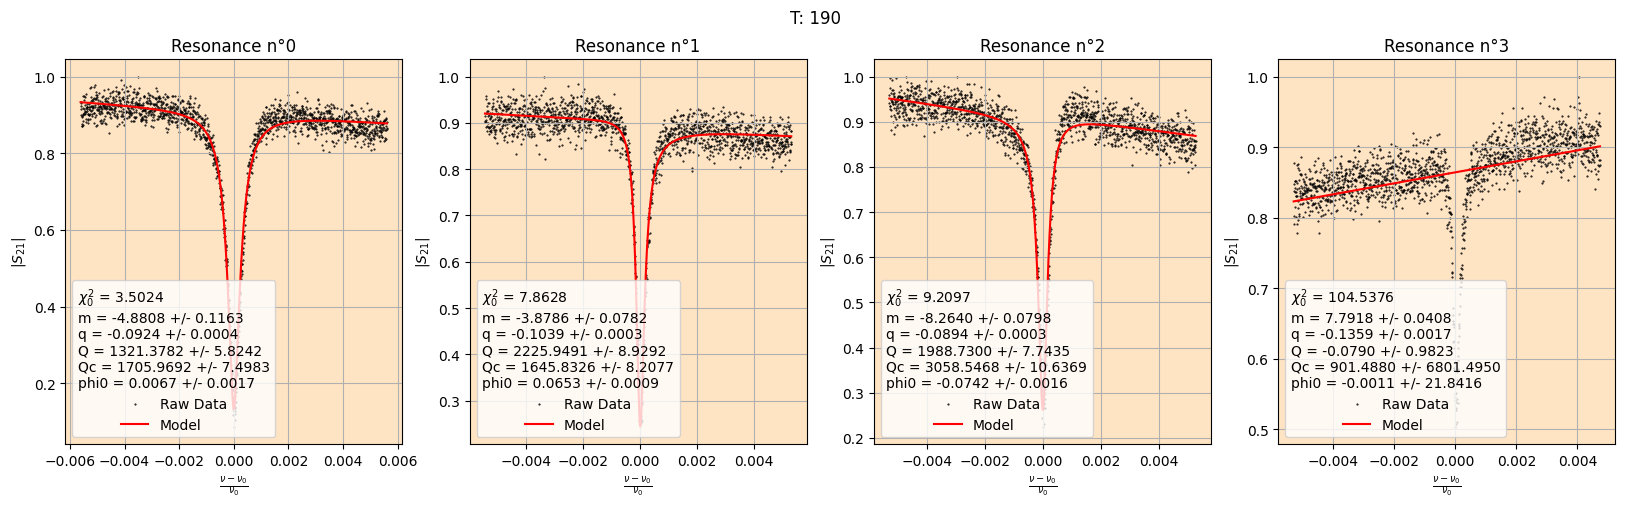

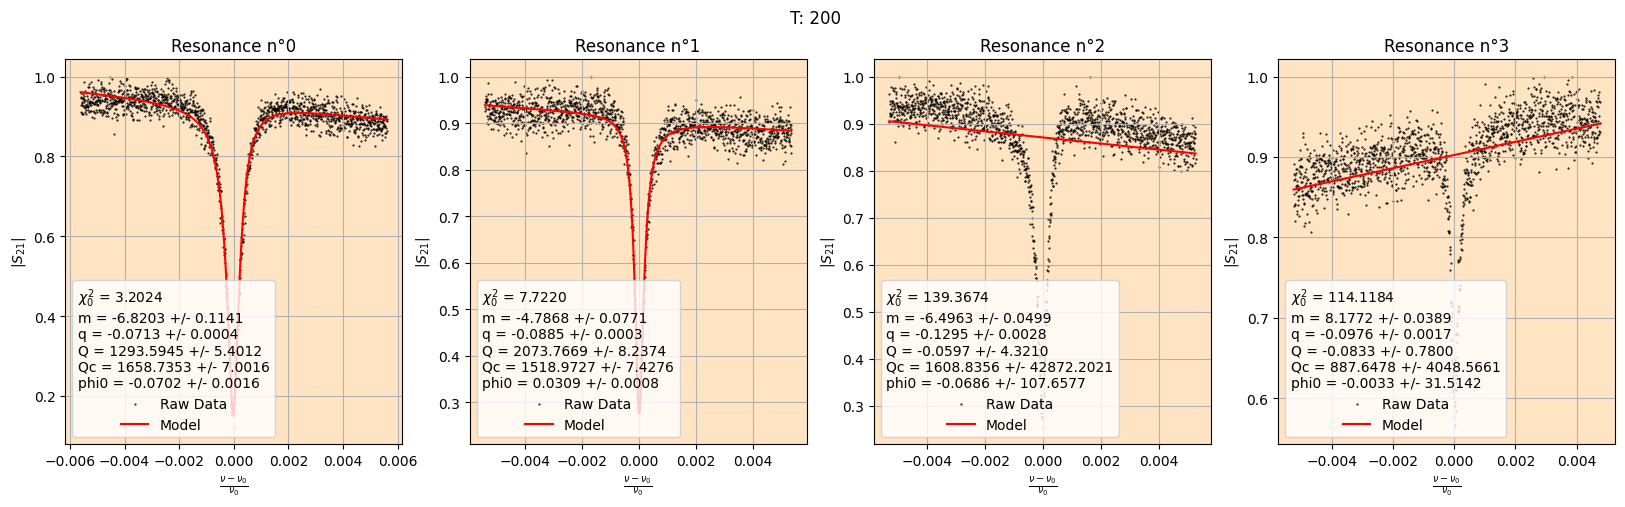

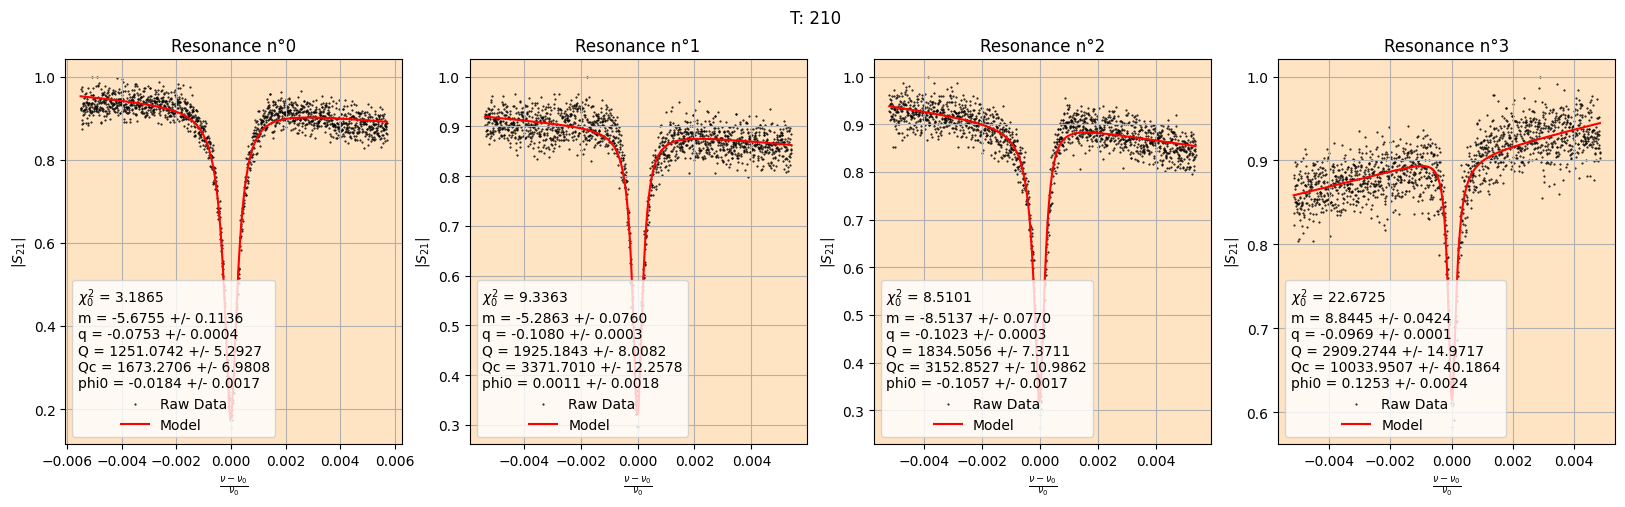

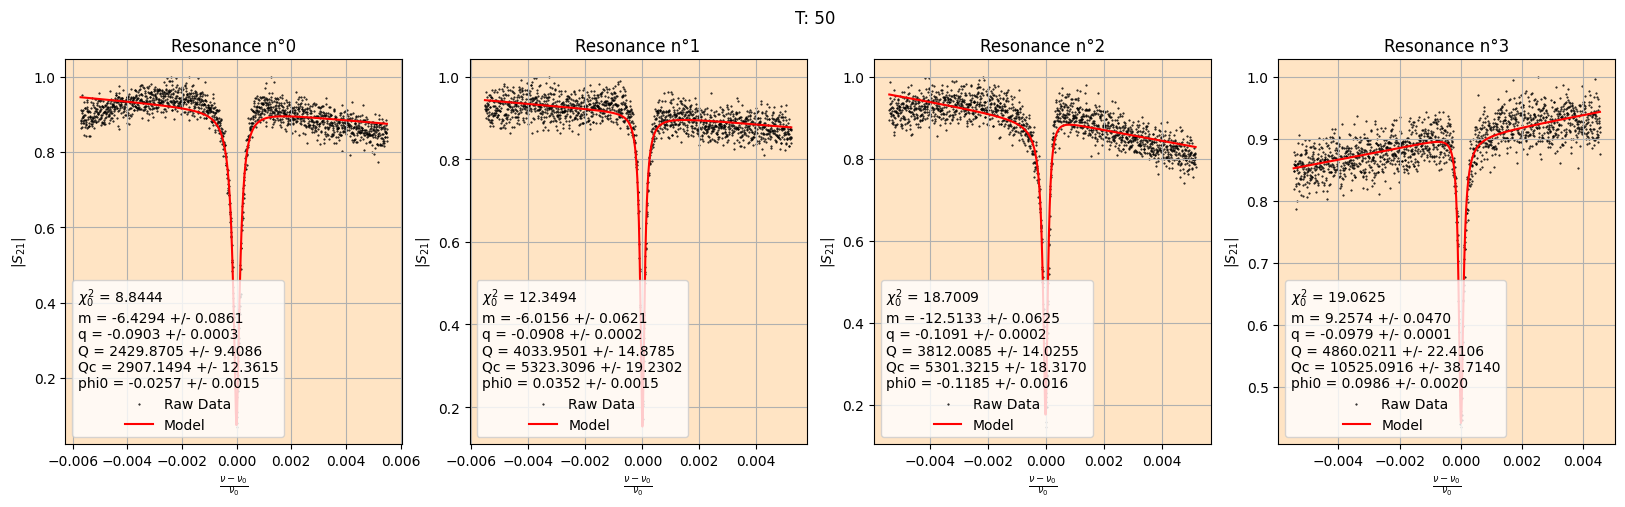

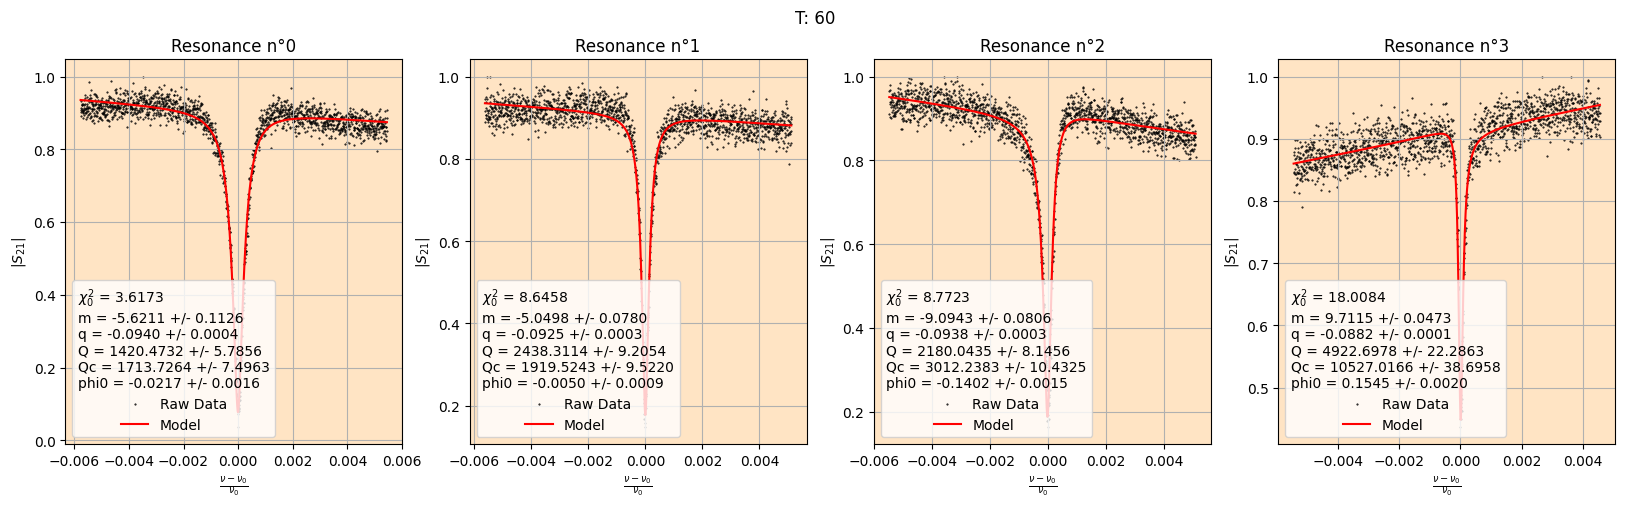

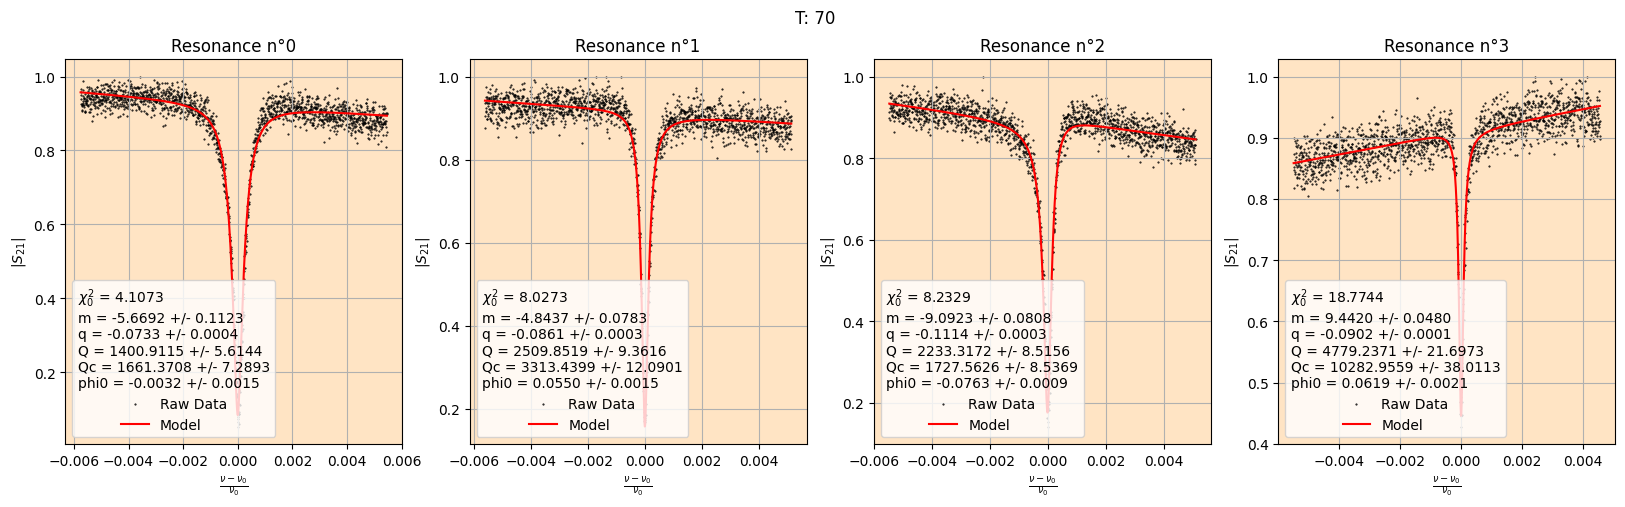

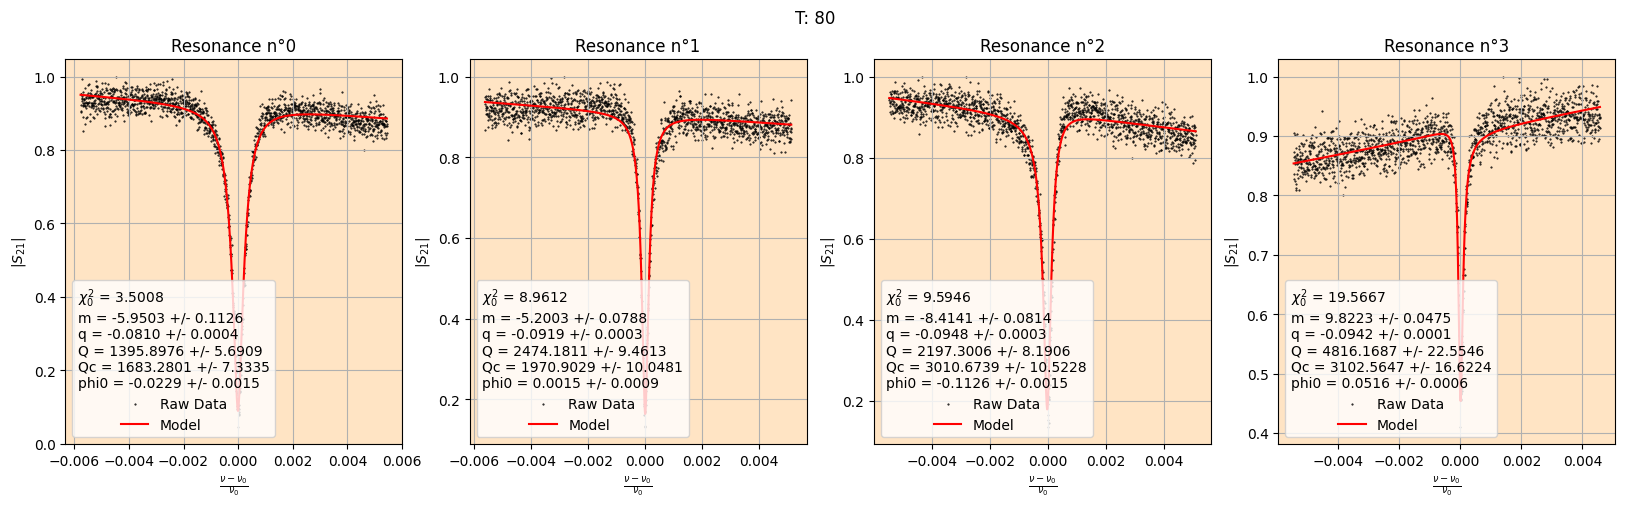

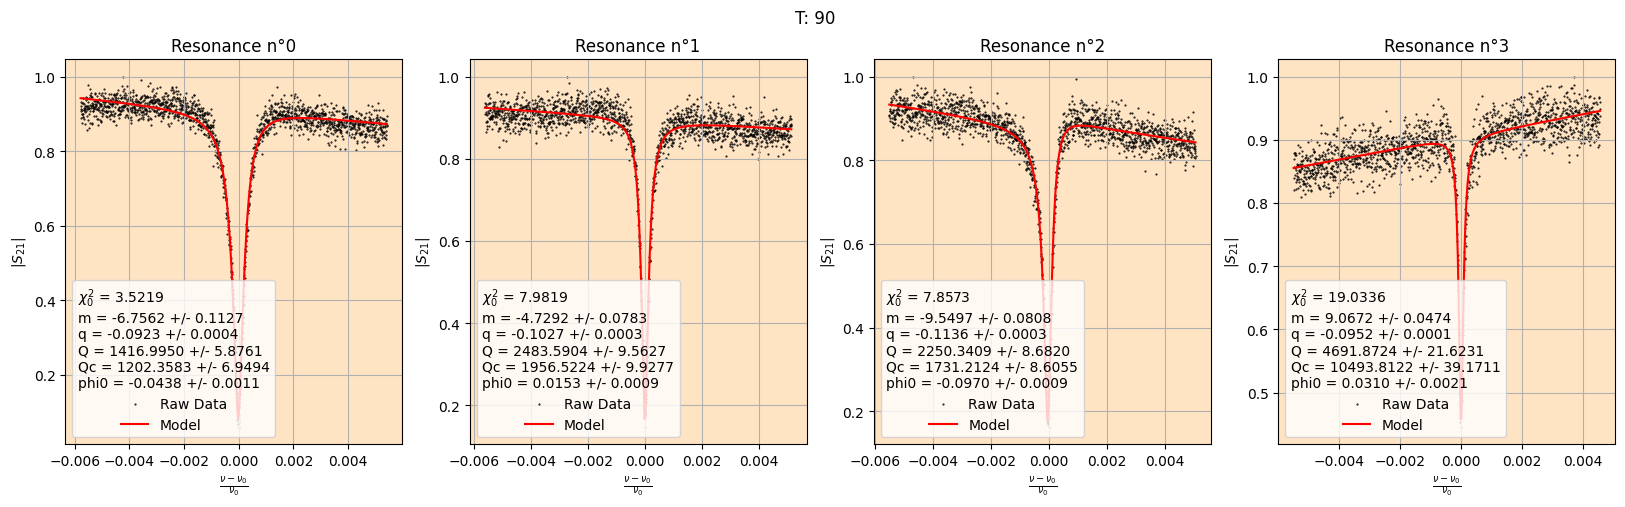

In [12]:
for i in range(len(dfs)):
    fig, axs = plt.subplots(1,4,figsize=(20,5))
    for j in range(4):
        axs[j].scatter(dfs[i][j]['f'], dfs[i][j]['S21'], marker='.', s=1, label='Raw Data', color='black')
        axs[j].plot(dfs[i][j]['f'], model(dfs[i][j]['f'], *m[i*4+j].values[:]), label='Model', color='red')
        #plt.fill_between(f, f-rms, f+rms, alpha=0.5, color='blue')
        axs[j].set_xlabel(r'$\frac{\nu- \nu_{0}}{\nu_{0}}$')
        axs[j].set_ylabel(r'$|S_{21}|$')
        axs[j].set_facecolor('bisque')
        axs[j].grid()

        chi2 = m[i*4+j].fval
        ndof = m[i*4+j].ndof

        title = [
            f"$\chi^{2}_{0}$ = {chi2/ndof:.4f}",
        ]

        for par in m[i*4+j].parameters:
            title.append(
                f"{par} = {m[i*4+j].values[par]:.4f} +/- {m[i*4+j].errors[par]:.4f}"
            )
        axs[j].legend(title="\n".join(title))
        axs[j].set_title('Resonance n°'+str(j))
    fig.suptitle('T: '+str(temps[i]))
    fig.show()
    fig.savefig('20_02_set2_'+str(i)+'.png')

In [13]:
Q_invs,Q_invs_err,Qs = [], [], []

import csv

with open('data_20_02_set2_phase.txt', 'w', newline='') as f:
    writer = csv.writer(f, delimiter='\t', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    h = ['T', '1/Q', '1/Q_err', 'phi']
    writer.writerow(h)
    for i in range(len(temps)):
        for j in range(4): 
            temp = [temps[i], 1/(m[i*4+j].values['Q']), 1/m[i*4+j].values['Q']**2 * m[i*4+j].errors['Q'], m[i*4+j].values['phi0']]
            writer.writerow(temp)

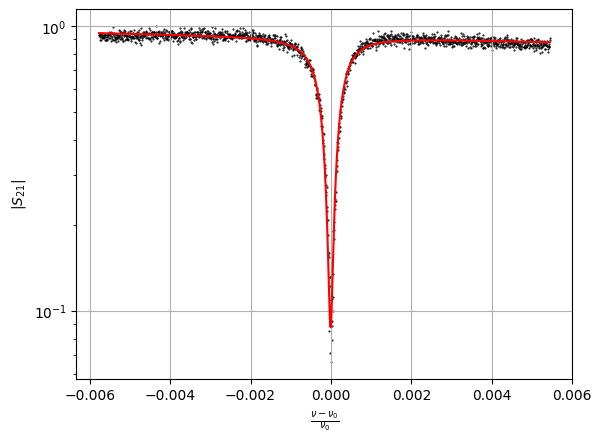

In [14]:
plt.scatter(dfs[0][0]['f'], dfs[0][0]['S21'], marker='.', s=1, label='Raw Data', color='black')
plt.plot(dfs[0][0]['f'], model(dfs[0][0]['f'], *m[0].values[:]), label='Model', color='red')
#plt.fill_between(f, f-rms, f+rms, alpha=0.5, color='blue')
plt.xlabel(r'$\frac{\nu- \nu_{0}}{\nu_{0}}$')
plt.ylabel(r'$|S_{21}|$')
plt.yscale('log')
plt.grid()